# Imaging problems in Geophysics: Full-waveform Inversion (Notebook 1)

<div class="alert alert-warning">
    
<h3>Contact details:</h3>

 - Dr. Rhodri Nelson
 - Room 4.96 RSM building
 - email: rhodri.nelson@imperial.ac.uk
 - Teams: <code>@Nelson, Rhodri B</code> (feel free to DM me)
</div>

This set of 4 lectures is intended as a practical introduction to the computational aspects of Full-waveform Inversion (FWI), a seismic based imaging method.

Other courses you may have done focus on different aspects of imaging frameworks (Seismic Processing - Data treatment, filtering etc., Seismic Techniques - Data acquisition and interpretation), here we will focus of the mathematical and computational aspects of the imaging process.

## Format:

- Lecture 1/2:
    - Overview of FWI
    - The wave-equation
    - Gradient descent methods
    - Theory of FWI
- Lecture 2:
    - Finish off notebook 1
    - The finite difference method
    - Introduction to Devito (the framework we'll be using to produce our FWI algorithms)
- Lecture 3:
    - Solving the wave-equation via the finite difference method
    - Forward propagators
- Lecture 4:
    - Implementing FWI algorithms
    - Comments and discussion regarding FWI

## Notes:

- Although, for completeness, we'll go through the general mathematical theory of FWI, the main aim of the lectures is to get everyone understanding the overall algorithm and the role of each component in the algorithm (rather than the mathematical details of, e.g., computing the adjoint).
- The exam question will be primarily focused on the 'outer-mathematics' and 'big-picture' aspects of the algorithm. This will become clearer as we progress through the material.
- To abstract some of the mathematical details and the complexities of the numerical implementation (so that we can play around with an FWI code by the end of the course) we'll make use of the python package Devito. This is an industry grade software developed within our department (and is used in industry for production FWI runs).
- Lectures will be presented in Jupyter notebooks. When Devito is required in lectures 2-4 you can use Google Colab or install everything locally. Instructions for Colab, Windows and Mac can be found towards the bottom of this notebook.

## Introduction

- FWI comprises a suite of minimally destructive techniques for measuring subsurface properties with applications in areas including hydrocarbon and mineral exploration, civil engineering and medical imaging.
- Such inversion problems constitute some of the most computationally demanding problems in industrial and academic research. An exploration scenario may look like the following:
    - $\mathcal{O}(10)^{3}$ FLOPs per loop iteration or high memory pressure.
    - 3D grids with > $10^9$ grid points.
    - Often more than 3000 time steps.
    - Two operators: forward + adjoint, to be executed 15 times.
    - Of the order of 30000 shots.
    - $\mathcal{O}$(billions) TFLOPs $\rightarrow$ Which means days, or weeks, or months on supercomputers!
    - Or, medical imaging problems for example are smaller but require accurate images to be available within ~10 minutes - requiring highly optimized code running on the latest GPU units.

Many of you will be familiar with ultrasound imaging techniques. Standard ultrasound scans are seismic based images. Medical FWI images are also seismic based, again utilizing ultrasound. So what are the key differences?

<img src="figures/us.jpg" alt="Drawing" style="width: 450px;"/>

- Standard ultrasound scans have a single wave-source and the emitting device also (often) contains the receiver.
- This means that only direct reflections are utilised to form an image.
- This vastly reduces the amount of detail you can resolve.
- However, this also means the imaging algorithms involved are numerically cheap and images can be rendered almost instantaneously.

<img src="figures/us_fwi1.png" alt="Drawing" style="width: 800px;"/>
<img src="figures/us_fwi2.png" alt="Drawing" style="width: 800px;"/>

Images from [*Guasch et. al. (2020)*](https://www.nature.com/articles/s41746-020-0240-8)

- In FWI algorithms on the other hand, we're trying to resolve the full wave-field, we hence need to collect and process **MUCH** more data.
- This leads to more accurate images ! And much higher computational complexity and cost...

Owing to the various challenges involved, the topic is by its nature multi-disciplinary, requiring geologists/clinicians/civil engineers who understand the 'big-picture', mathematicians to build efficient numerical schemes and HPC specialists to turn these models into optimised HPC code!
- Studying such problems requires the use of advanced numerical packages. In this course we'll use **Devito**, a numerical software package developed within our department that is used within production FWI codes.

## Some other applications

Ultrasound waves have frequencies of $20KHz$ or more. Seismic based FWI with much lower frequency waves (10-20Hz or so) is also used for geophysical imaging applications such as in volcanology and geophysical exploration.

<tr>
    <td> <img src="figures/survey-ship-diagram.png" alt="Drawing" style="width: 450px;"/> </td>
    <td> <img src="figures/Marmousi3D.png" alt="Drawing" style="width: 450px;"/> </td>
</tr>

**Left:** Sketch of offshore seismic survey. **Right:** Example model result for $v_p$.

- FWI is also used for structural health monitoring e.g. imaging/(locating) damage in damns, mine shafts and other 'difficult to access' structures. In these applications seismics or ground penetrating radar can be used.

As larger and larger simulations become more affordable in the coming years, I predict that more and more fields of science and engineering will make use of FWI.

### And a slightly more detailed description...

With the above in mind, lets consider a slightly more detailed description.

Full-waveform inversion (FWI) is a computational scheme for generating high-resolution, high-fidelity models of physical properties using finite-frequency waves. The waves could be electromagnetic, acoustic, elastic or of various other kinds. The method is used in medical imaging of soft tissues, in non-destructive testing, in petroleum exploration, in earthquake seismology, and to image the interior of the Sun. FWI is a form of tomography, but conventional tomography assumes that energy travels along infinitely thin geometric ray paths, that there are no finite-frequency wave effects, and that it is necessary only to fit a single amplitude or travel-time for each source-and-receiver pair. In contrast, FWI attempts to fully account for the finite wavelength of the observed signals, and it seeks to explain the detailed waveforms of the recorded data.

Like other simpler forms of tomography, FWI is a local, iterated inversion scheme that successively improves a starting model. It does this by using the two-way wave equation to predict the observed data from a model, and then seeks to find a new model that minimises the differences between those predictions and the observed data; it attempts to match the raw observed data wiggle for wiggle. The computational effort required for FWI is large, but the resulting spatial resolution is much better than can be obtained by conventional tomography - it has only become economically feasible for three-dimensional models in the last ten years or so. The notation used is summarised at the end of these notes, together with definitions of the $L_2-norm$, the *gradient* and the *Hessian*.

## The FWI algorithm outline

The aim of FWI is find a model that minimises some measure of the misfit between a dataset predicted by a model and an observed dataset - this measure is called the *objective function*.

A simple geometric analogy, in which the model has just two parameters, is to regard the misfit as being represented by the local height of a two-dimensional error surface, and the two model parameters as representing the $x$ and $y$-coordinates of a point on this surface. FWI then involves starting at some point on this surface, and trying to find the bottom of the deepest valley by heading downhill in a sequence of finite steps. To do this, we have to discover which way is downhill, and how far to step. In real FWI, the model has not just two parameters, but many millions, but the analogy is still appropriate. The algorithm proceeds as follows:
1. Calculate the direction of the local gradient $\nabla_\mathbf{m}$ of the objective function f with respect to the model parameters - this points uphill
    - Using the *starting model* $\mathbf{m}$ and a known *source* $\mathbf{s}$, calculate the forward *wavefield* $\mathbf{u}$ everywhere in the model including the *predicted data* $\mathbf{p}$ at the receivers.
    - At the receivers, subtract the observed data d from the predicted data to obtain the *residual data* $\delta\mathbf{d}$.
    - Treating the receivers as virtual sources, back-propagate the residual data into the model, to generate the residual wavefield $\delta\mathbf{u}$.
    - Scale the residual wavefield by the local slowness $1/c$, or squared slowness $1/c^2$, and differentiate it twice in time. (But don't worry too much about this, we can abstract it into the maths).
    - At every point in the model, cross-correlate the forward and scaled residual wavefields, and take the zero lag in time to generate the *gradient* for one source.
    - Do this for every source, and stack together the results to make the global gradient.
2. Find the step length - how far is the bottom of the hill?
    - Take a small step and a larger step directly downhill, and calculate the objective function at the current model and in these two new models.
    - Assume a linear relationship between changes in the model and changes in the residual data so that there will be a parabolic relationship between changes in the model and changes in the objective function, then fit a parabola through these three points.
    - The lowest point on this parabola represents the optimal step length (assuming a locally linear relationship).
    - Step downhill by the required amount, and update the model.
3. Do it all over again
    - Use the new model as the starting model, and repeat steps 1. and 2.
    - Repeat this process until the model is 'good enough', that is the model is no longer changing (to some numerical tolerance), or we run out of time, money or patience.

This is the basic algorithm. There are several ways to enhance and improve it, but nearly all of these involve a greater computational cost (which is already high).

## The Wave Equation

The wave equation is a simplified model for, i.e. the displacement of a vibrating
string (approx. 1D), a membrane (such as a drum skin, approx. 2D) or an elastic solid in 3D (the situation relevant to FWI). That is, the main physics the wave equation is attempting to capture is, broadly speaking, the transfer through space of oscillatory energy (vibrations in time).

The simplest wave equation that is commonly used in FWI is:
$$
\begin{equation}
  \frac{1}{c^2}\frac{\partial^2 u}{\partial t^2}-\nabla^2 u = s,
 \tag{1}
\end{equation}
$$
where $u$ is the propagating wavefield measured using some appropriate material property (for example electric field in an EM wave or acoustic pressure in an acoustic wave), $s$ is the driving source that produces the wavefield, and $c$ is the wave speed. Both $u$ and $s$ vary in space and time, and c varies in space. This equation applies to small-amplitude linear waves propagating within an inhomogeneous, isotropic, constant-density, non-attenuating, non-dispersive, fluid medium. It is relatively straightforward to add variable density, shear
strength, attenuation, anisotropy, dispersion, polarisation and other physical effects to this simple wave equation; these effects change the detailed equations and numerical complexity, but not the general approach.

### Simplified derivation of the 1D wave-equation

For a simple derivation of the 1D acoustic wave equation let us focus on an isotropic and homogeneous elastic string, where $u(x, t)$ describes displacement or 'height' from the position of rest at position $x$ and time $t$. We consider a
small subinterval $[x_1, x_2]$. The total acceleration, $a$, in the '$u$'-direction within this interval is
$$
\begin{equation}
   a=\partial_t^2\int_{x_1}^{x_2}u(x,t)\mathrm{d}x=\int_{x_1}^{x_2}u_{tt}(x,t)\mathrm{d}x.
\tag{2}
\end{equation}
$$
The total force acting on this interval of the string is the net force of the forces
acting at the points $x_1$ and $x_2$. The force $F=F(u)$ will be some function
of $u$. By Newton’s law, force equals acceleration for unit mass and hence
$$
\begin{equation}
  a = F(u(x_2,t))-F(u(x_1,t))=\int_{x_1}^{x_2}F_{x}(u(x,t))\mathrm{d}x.
\tag{3}
\end{equation}
$$
We are now required to make some assumptions. Let us assume that the force $F$ is proportional to the slope of the string with a proportionality factor $c^2$ (can be justified for small displacements). Hence
$$
\begin{equation}
  F(u) \approx c^2 u_x.
\tag{4}
\end{equation}
$$
Combining the above yields
$$
\begin{equation}
  \int_{x_1}^{x_2}(u_{tt}-c^2 u_{xx})\mathrm{d}x=0.
\tag{5}
\end{equation}
$$
Since this holds for an arbitrary interval $[x_1, x_2]$, we must have that
$$
\begin{equation}
  \frac{1}{c^2}u_{tt}=u_{xx},
\tag{6}
\end{equation}
$$
which is the 1D wave equation. Similar arguments (albeit using vector calculus) can be made to derive the corresponding wave equation in two or three dimensions.

### Other forms of the wave equation

More general forms of the wave equation can be written as
$$
\begin{equation}
  \rho(\mathbf{x})\frac{\partial^2 \mathbf{u}}{\partial t^2}(\mathbf{x},t)-\nabla\cdot\mathbf{\sigma}(\mathbf{x},t)=\mathbf{f}(\mathbf{x},t),
\tag{7}
\end{equation}
$$
where $\mathbf{u}(\mathbf{x},t)$ is the displacement field and $\rho(\mathbf{x})$, $\mathbf{\sigma}(\mathbf{x},t)$, and $\mathbf{f}(\mathbf{x},t)$ represent the material density, stress tensor and an external force density respectively. Depending on the fidelity of model we wish to implement, $\mathbf{\sigma}(\mathbf{x},t)$ can take on many different forms (the simplest, as we'll see below, resulting in the acoustic wave equation defined above). For example, the acoustic wave equation only accounts for the propagation of *pressure waves* (P-waves) but the propagation of *shear waves* (S-waves) is also important in many physical problems. In the *elastic wave equation*, which accounts for the propagation of both P- and S-waves (i.e. both longitudinal and transverse motions) the stress tensor can be written as (dropping function dependencies for conciseness)
$$
\begin{equation}
  \sigma_{ij}=\sum_{k,l=1}^{3}(\lambda\delta_{ij}\delta_{kl}+\mu\delta_{ik}\delta_{jl}+\mu\delta_{il}\delta_{jk})\varepsilon_{kl},
 \tag{8}
\end{equation}
$$
where
$$
\begin{equation}
  \varepsilon_{ij}=\frac{1}{2}(\partial_{i}u_{j}+\partial_{j}u_{i})
\tag{9}
\end{equation}
$$
and $\lambda$ and $\mu$ and known as *Lame parameters* (which are determined by the physical properties of the isotropic homogeneous elastic medium). Note that in the formulations introduced so far, energy is not dissipated - one formulation in which energy is dissipated is know as the *viscoelastic wave equation*. We will not discuss this formulation here, but for interested readers details regarding viscoelastic formulations (along with acoustic and elastic) and details regarding FWI in general can be found in the book entitled **Full Seismic Waveform Modelling and Inversion** by **Andreas Fichtner**.

In the fluid regions of the Earth (e.g. oceans and outer core) the shear modulus $\mu$ (one of the *Lame parameters*) is effectively zero. In such cases the stress tensor reduces to
$$
\begin{equation}
  \sigma_{ij} = \kappa\delta_{ij}\nabla\cdot\mathbf{u}=-p\delta_{ij},
\tag{10}
\end{equation}
$$
where we have introduced the scalar pressure $p:=-\kappa\nabla\cdot\mathbf{u}$ and $\kappa$ ($=\lambda+\frac{2}{3}$) is the *bulk modulus* (which has a more straightforward physical interpretation). Hence, (7) reduces to
$$
\begin{equation}
  \rho\ddot{\mathbf{u}}+\nabla p = \mathbf{f}.
\tag{11}
\end{equation}
$$
(Note: $\ddot{f}\equiv\frac{\partial^2 f}{\partial t^2}$.) Dividing by the density $\rho$ and taking the divergence gives
$$
\begin{equation}
  \nabla\cdot\ddot{\mathbf{u}}+\nabla\cdot(\rho^{-1}\nabla p) = \nabla\cdot(\rho^{-1}\mathbf{f}).
\tag{12}
\end{equation}
$$
Using our definition of pressure we can then eliminate $\mathbf{u}$ leaving
$$
\begin{equation}
  \kappa^{-1}\ddot{p}-\nabla\cdot(\rho^{-1}\nabla p) = -\nabla\cdot(\rho^{-1}\mathbf{f}).
\tag{13}
\end{equation}
$$
Provided density varies much slower than the pressure field $p$ and the source term $\mathbf{f}$ we can further simply to obtain
$$
\begin{equation}
  \ddot{p}-v_p^2\nabla^2p=-v_p^2\nabla\cdot\mathbf{f},
\tag{14}
\end{equation}
$$
with the *acoustic wave speed* $v_a:=\sqrt{\frac{\kappa}{\rho}}$. This is of course the 'main' equation of FWI introduced earlier when we let the wavefield $u=p$, the wave speed $c=v_p$ and 'abstracting away' any intricacies in the source term such we have simply $-v_p^2\nabla\cdot\mathbf{f}=s$.


### Matrix form

The wave equation represents a linear relationship between a wavefield $u$ and the source $s$ that generates the wavefield. After discretisation (with for example finite differences) we can therefore write (1) as a matrix equation

\begin{equation}
  \mathbf{A}\mathbf{u}=\mathbf{s},
\tag{15}
\end{equation}

where $\mathbf{u}$ and $\mathbf{s}$ are column vectors that represent the source and wavefield at discrete points
in space and time, and $\mathbf{A}$ is a matrix that represents the discrete numerical implementation of the operator

\begin{equation}
  \frac{1}{c^2}\frac{\partial^2}{\partial t^2}-\nabla^2.
\tag{16}
\end{equation}

Although the wave equation represents a linear relationship between $u$ and $s$, it also represents a non-linear relationship between a model $\mathbf{m}$ and wavefield $\mathbf{u}$. Thus we can also write the wave equation as

\begin{equation}
  G(\mathbf{m})=\mathbf{u}.
\tag{17}
\end{equation}

Here $\mathbf{m}$ is a column vector that contains the model parameters. Commonly these will be the values of $c$ at every point in the model, but they may be any set of parameters that is sufficient to describe the model, for example squared slownesses $1/c^2$. Note that in equation (17) $G$ is not a matrix; it is a (non-linear) function that describes how to calculate a wavefield $\mathbf{u}$ given a model $\mathbf{m}$.

Note that the form of matrix $\mathbf{A}$ depends upon both the model properties and the details of the numerical implementation, and that the form of the function $G$ depends upon the source and the acquisition geometry. The form of $\mathbf{A}$ does not depend upon the source and the form of $G$ does not depend upon the model.

It is common in FWI to construct the numerical wave equation in (15) such that the matrix
$\mathbf{A}$ represents a wave travelling forward in time, and its transpose represents a wave travelling
backwards in time. This is not essential, but it is often straightforward to achieve, in which
case it simplifies the numerics of FWI.

## The Objective Function

The central purpose of FWI is to find a physical model of the wave-transmitting medium that
minimises the difference between an observed dataset and the same dataset as predicted by
the model. Consequently we need a means to measure this difference. There are many ways
to do this, but the most common is a *least-squares* formulation where we seek to minimise the
sum of the squares of the differences between the two datasets over all sources and receivers,
and over all times. That is, we seek to find a model that minimises the square of the $L_2-norm$
of the *data residuals*.

The $L_2-norm$ expresses the misfit between the two datasets as a single number. This number
is variously called the *cost function*, the *objective function*, the *misfit function*, or just the
*functional*. It is typically given the symbol $f$. It is a real positive scalar quantity, and it is
a function of the model $\mathbf{m}$. In practice, a factor of a half is often included in the definition
of the objective function to 'simplify' the formulation (as we will see later). Define:

\begin{equation}
  f(\mathbf{m})=\frac{1}{2}||\mathbf{p}-\mathbf{d}||^2=\frac{1}{2}||\delta\mathbf{d}||^2=\frac{1}{2}\delta\mathbf{d}^{T}\delta\mathbf{d}=\frac{1}{2}\sum_{n_s}\sum_{n_r}\sum_{n_t}|p-d|^2,
\tag{18}
\end{equation}

where $n_s$, $n_r$ and $n_t$ are the number of sources, receivers and time samples in the data set,
and $\mathbf{d}$ and $\mathbf{p}$ are the observed and predicted datasets.

To minimise this function with respect to the model parameters $\mathbf{m}$, we have to differentiate
$f$ with respect to $\mathbf{m}$, set the differentials equal to zero, and solve for $\mathbf{m}$.

## Local Inversion

FWI is a local iterative inversion scheme. It begins from a starting model $\mathbf{m}_0$ that is
assumed to be sufficiently close to the true model, and it seeks to make a series of step-wise
improvements to this model which successively reduce the objective function towards zero.
Thus, we need to consider the objective function for a starting model $\mathbf{m}_0$ and a new model
$\mathbf{m}=\mathbf{m}_0+\delta\mathbf{m}$.

*In the examples we will cover, by **model**, we refer to some quantity related to the wave-speed at each of our computational domains grid points. If our computational domain contains 100x100 grid points for example, our **model** would be a vector of length 10,000.*

Recall the Taylor series, truncated to second order, for a scalar function of a single *scalar*
variable is

\begin{equation}
  f(x) = f(x_0+\delta x)=f(x_0)+\delta x\frac{\mathrm{d} f}{\mathrm{d} x}\biggr|_{x=x_0}+\frac{1}{2}\delta x^2 \frac{\mathrm{d}^2f}{\mathrm{d}x^2}\biggr|_{x=x_0}+\mathcal{O}(\delta x^3).
\tag{19}
\end{equation}

\begin{equation}
f(x) = f(x_0) + \delta x \cdot \frac{df}{dx}\Bigg|{x = x_0} + \frac{1}{2} (\delta x)^2 \cdot \frac{d^2 f}{dx^2}\Bigg|{x = x_0} + \mathcal{O}((\delta x)^3)
\end{equation}

Before considering a routine for minimising the function $f(x)$, lets recall how we can use the Taylor series to form an algorithm to find the zeros of a function. Given an initial guess $x_0$ *close* (enough) to a zero, we wish to update our guess such that

\begin{equation}
 f(x_0+\delta x)=0.
\end{equation}

That is, we want to add some $\delta x$ to our initial guess $x_0$ such that when we re-evaluate our function at $x_0+\delta x$ we get zero! Lets use the Taylor series above to work out how we should choose $\delta x$.

First, we need to be close enough to the solution such that $\delta x$ is small (we need this to be true so that this is a local inversion problem). If $\delta x$ is small, then $\delta x^2$ should be very small. Hence, we will neglect $\delta x$ and higher order terms in our algorithm.

Note that since we are neglecting higher order terms, $f(x_0+\delta x)$ will not be zero. However, it *should be* closer to zero. Re-arranging the Taylor series we have

\begin{equation}
 \delta x = \frac{f(x_0+\delta x)-f(x_0)}{f'(x_0)}.
\end{equation}

We want $f(x_0+\delta x)$ to be zero and hence we should choose $\delta x$ to be

\begin{equation}
 \delta x = -\frac{f(x_0)}{f'(x_0)}.
\end{equation}

Therefore, given an $x_0$, we can continuously apply this procedure to get closer and closer to the root:

\begin{equation}
 x_{n+1}=x_{x}-\frac{f(x_n)}{f'(x_n)}.
\end{equation}

**Exercise:** In the cell below, write a snippet of code to find the root of $f(x)=e^{x}+x$.

In [6]:
import numpy as np

# Code to solve e^{x}+x=0:
def f(x):
    return np.exp(x) + x
def df(x):
    return np.exp(x) + 1
x0 = 0.
iter = 10
tot = 1e-6
for i in range(iter):
    x0 = x0 - (f(x0) / df(x0))
    if f(x0) < tot:
        break
print (f(x0))
print (df(x0))
print (x0)


1.964804717813351e-07
1.5671433615153338
-0.5671431650348622


In [4]:
import sympy as sp
x = sp.symbols('x')
f = (sp.exp(x) + x)
f_prime = sp.diff(f,x)
f_prime

exp(x) + 1

Minimising functions is not dissimilar. Since at a minimum $f'(x)=0$, we simply need to differentiate the function of interest and then apply the above procedure to the derivative. Lets go back to the Taylor series to work out how to do this. First, we need to differentiate it

\begin{equation}
  \frac{\partial}{\partial x}f(x_0+\delta x)=\frac{\partial}{\partial x}f(x_0)+\frac{\partial}{\partial x}\delta x\frac{\mathrm{d} f}{\mathrm{d} x}\biggr|_{x=x_0}+\frac{\partial}{\partial x}\frac{1}{2}\delta x^2 \frac{\mathrm{d}^2f}{\mathrm{d}x^2}\biggr|_{x=x_0}+\frac{\partial}{\partial x}\mathcal{O}(\delta x^3).
\end{equation}

Neglecting resulting terms with $\delta x^2$ or greater gives

\begin{equation}
 \frac{\partial}{\partial x}f(x_0+\delta x)=0+\frac{\mathrm{d} f}{\mathrm{d} x}\biggr|_{x=x_0}+\delta x \frac{\mathrm{d}^2f}{\mathrm{d}x^2}\biggr|_{x=x_0}.
\end{equation}

Since we want $f(x_0+\delta x)=0$, we therefore have

\begin{equation}
 \delta x = -\frac{f'(x_0)}{f(x_0)}.
\end{equation}

and can write our update scheme as

\begin{equation}
 x_{n+1}=x_{x}-\frac{f'(x_n)}{f''(x_n)}.
\end{equation}

**Exercise:** In the cell below, write a snippet of code to find the minimum of $f(x)=e^{x}-x$.

In [10]:
# Code to find the minimum of e^{x}-x:

def f(x):
    return np.exp(x)-  x
def df(x):
    return np.exp(x) - 1
def ddf(x):
    return np.exp(x)
tot = 1.e-6
x0 = 0
iter = 100
for i in range(iter):
    x0 = x0 - (df(x0) / ddf(x0))
    if abs(df(x0)) < tot:
        break
print (df(x0))
print (x0)
print ('the minimum of the equation is', f(x0))

0.0
0.0
the minimum of the equation is 1.0


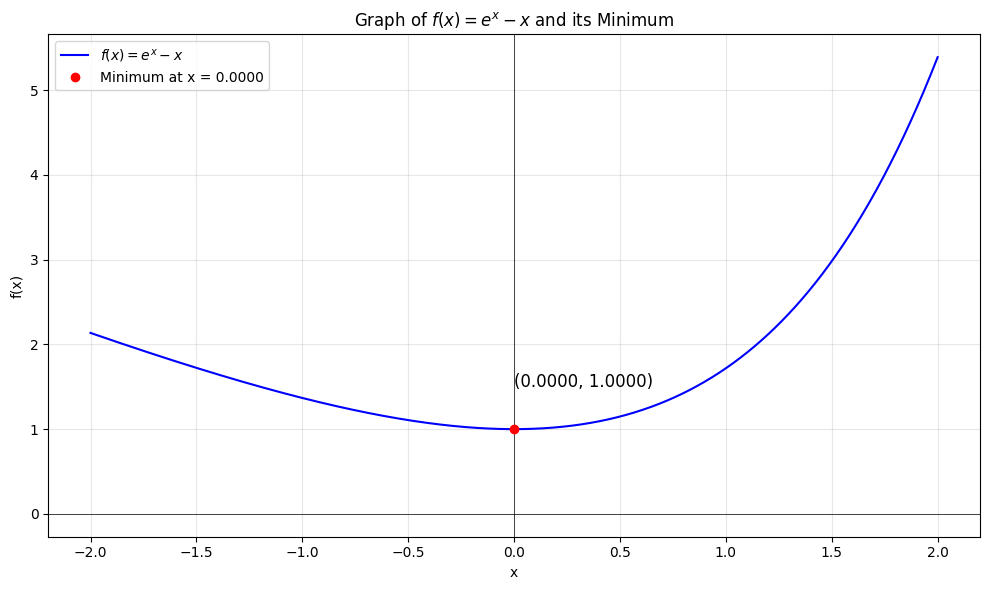

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# 定义函数及其导数和二阶导数
def f(x):
    return np.exp(x) - x

def df(x):
    return np.exp(x) - 1

def ddf(x):
    return np.exp(x)

# 牛顿-拉夫森法找到最小值
tol = 1.e-6
x0 = 0
max_iter = 100

for i in range(max_iter):
    x0 = x0 - df(x0) / ddf(x0)
    if abs(df(x0)) < tol:
        break

# 最小值点和对应的函数值
x_min = x0
y_min = f(x_min)

# 绘制函数曲线
x_vals = np.linspace(-2, 2, 1000)
y_vals = f(x_vals)

plt.figure(figsize=(10, 6))
plt.plot(x_vals, y_vals, label=r"$f(x) = e^x - x$", color='blue')
plt.axhline(0, color='black', lw=0.5)
plt.axvline(0, color='black', lw=0.5)

# 标注最小值点
plt.plot(x_min, y_min, 'ro', label=f"Minimum at x = {x_min:.4f}")
plt.text(x_min, y_min + 0.5, f"({x_min:.4f}, {y_min:.4f})", fontsize=12)

plt.xlabel('x')
plt.ylabel('f(x)')
plt.title('Graph of $f(x) = e^x - x$ and its Minimum')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

### Generalising to vectors

In our case however, the variable is not a single scalar, it will be a vector as mentioned above. For a scalar function of a *vector*, the analogous expression is

\begin{equation}
  f(\mathbf{m}) = f(\mathbf{m}_0+\delta\mathbf{m})=f(\mathbf{m}_0)+\delta\mathbf{m}^T\frac{\partial f}{\partial \mathbf{m}}\biggr|_{\mathbf{m}=\mathbf{m}_0}+\frac{1}{2}\delta\mathbf{m}^T \frac{\partial^2f}{\partial \mathbf{m}^2}\biggr|_{\mathbf{m}=\mathbf{m}_0}\delta\mathbf{m}+\mathcal{O}(\delta \mathbf{m}^3).
\tag{20}
\end{equation}

Now we must differentiate this equation with respect to $\mathbf{m}$, and set the result to zero in order to
minimise $f$ with respect to $\mathbf{m}_0+\delta\mathbf{m}$. In the following we will use the well known result that

\begin{equation*}
 \frac{\partial}{\partial\mathbf{x}}\left(\mathbf{x}^TA\mathbf{x}\right)=\left(\mathbf{x}^TA\right)^T+A\mathbf{x}.
\end{equation*}

Note that differentiating with respect to $\mathbf{m}$ is the same as differentiating with respect to $\delta\mathbf{m}$ because $\mathbf{m}_0$ is constant. Note also that $f$, $\partial f/\partial\mathbf{m}$ and $\partial^2 /f\partial\mathbf{m}^2$, evaluated at $\mathbf{m}=\mathbf{m}_0$, do not depend upon $\delta\mathbf{m}$. Thus, when we differentiate equation with respect to $\mathbf{m}$, we obtain

\begin{equation}
  \frac{\partial f}{\partial \mathbf{m}}\biggr|_{\mathbf{m}=\mathbf{m}_0+\delta \mathbf{m}} = \frac{\partial f}{\partial \mathbf{m}}\biggr|_{\mathbf{m}=\mathbf{m}_0}+\left(\frac{1}{2}\delta\mathbf{m}^T \frac{\partial^2f}{\partial \mathbf{m}^2}\biggr|_{\mathbf{m}=\mathbf{m}_0}\right)^T+\frac{1}{2}\frac{\partial^2f}{\partial \mathbf{m}^2}\biggr|_{\mathbf{m}=\mathbf{m}_0}\delta\mathbf{m}+....
\tag{21}
\end{equation}

Setting this equal to zero, using the fact $\partial^2 f/\partial \mathbf{m}^2$ is symmetric and hence combining the two middle terms, gives

\begin{equation}
  \frac{\partial f}{\partial \mathbf{m}}\biggr|_{\mathbf{m}=\mathbf{m}_0}+\frac{\partial^2f}{\partial \mathbf{m}^2}\biggr|_{\mathbf{m}=\mathbf{m}_0}\delta\mathbf{m}+\mathcal{O}(\delta\mathbf{m}^2)=0.
\tag{22}
\end{equation}

Neglecting second-order terms, and rearranging, gives an expression for the update to the
model $\delta\mathbf{m}$:

\begin{equation}
  \delta\mathbf{m} \approx - \left(\frac{\partial^2 f}{\partial\mathbf{m}^2}\right)^{-1}\frac{\partial f}{\partial\mathbf{m}} \equiv -\mathbf{H}^{-1}\nabla_{\mathbf{m}}f.
\tag{23}
\end{equation}

Here $\nabla_{\mathbf{m}}f$ is the *gradient* of the objective function $f$ with respect to the model parameters,
and $\mathbf{H}$ is the *Hessian* matrix of second differentials, both evaluated at $\mathbf{m}_0$.

If the model has $n$ parameters, then the gradient is a column vector of length $n$, and the
Hessian is an $n \times n$ symmetric matrix. Methods that solve the inversion problem using
equation (23) directly are called *Newton* methods. Methods that use equation (23) with a
'reasonable' approximation to the Hessian are called Gauss-Newton or quasi-Newton methods
depending upon how the approximation is formulated.

## Steepest Descent

If the number of model parameters $n$ is large, calculating the Hessian is a major
undertaking, and inverting it is not normally computationally feasible. Consequently the
method that is typically used is to replace the inverse of the Hessian in equation ([23](#mjx-eqn-li4)) by a
simple scalar $\alpha$; this scalar is called the step length. We now have

\begin{equation}
  \delta\mathbf{m} = -\alpha\frac{\partial f}{\partial \mathbf{m}} = -\alpha\nabla_{\mathbf{m}}f.
  \tag{24}
\end{equation}

The method that uses this approach is called the method of *steepest descent*, and in its
simplest form it consists of the following steps:
1. start from a model $\mathbf{m}_0$,
2. evaluate the gradient of the objective function, $\nabla_{\mathbf{m}}f$, for the current model,
3. find the step length $\alpha$,
4. subtract $\alpha$ times the gradient from the current model to obtain a new model,
5. iterate from step 2 using the new model until the objective function is sufficiently small (or we run out of patience).

That is, we need to implement the model update scheme

\begin{equation}
 \mathbf{m}_{n+1}=\mathbf{m}_n-\alpha\nabla_{\mathbf{m}}f.
\end{equation}

(Note that compared to the scalar case, $\nabla_{\mathbf{m}}f$ is analogous to $f'(x_n)$ and $\alpha$ to $1/f''(x_n)$). To implement this, we need a method of calculating the local gradient.

## Calculating the gradient

In principle, we could find the gradient by perturbing each of the model parameters in turn,
and calculating what happens to the objective function each time. For $n$ model parameters,
that would require $n+1$ modelling runs, and this is not computationally feasible. Fortunately
there is a faster way using a solution to the *adjoint* problem.

First, write the gradient in terms of the residual data $\delta\mathbf{d}=\mathbf{p}-\mathbf{d}$:
$$
\begin{equation}
  \nabla_{\mathbf{m}}f=\frac{\partial f}{\partial \mathbf{m}}=\frac{\partial}{\partial \mathbf{m}}\left(\frac{1}{2}\delta\mathbf{d}^T\delta\mathbf{d}\right)=\frac{\partial (\mathbf{p}-\mathbf{d})^T}{\partial \mathbf{m}}\delta\mathbf{d}=\left(\frac{\partial \mathbf{p}}{\partial \mathbf{m}}\right)^T\delta\mathbf{d}.
\tag{25}
\end{equation}
$$
Now, write the wave equation for a dataset $\mathbf{p}$ generated by a source $\mathbf{s}$ as

\begin{equation}
  \mathbf{Au}=\mathbf{s},
\tag{26}
\end{equation}

where $\mathbf{p}$ is the subset of the full wavefield $\mathbf{u}$ that is located at the receiver positions.
Mathematically, we can extract the data at the receivers from the data everywhere in the
model simply by using a diagonal *restriction* matrix $\mathbf{R}$ that has non-zero unit values only
where there exists observed data. That is

\begin{equation}
  \mathbf{p}=\mathbf{Ru}.
\tag{27}
\end{equation}

Now, differentiate equation (26) with respect to $\mathbf{m}$ to obtain

\begin{equation}
  \frac{\partial\mathbf{A}}{\partial\mathbf{m}}\mathbf{u}+\mathbf{A}\frac{\partial\mathbf{u}}{\partial\mathbf{m}}=\frac{\partial\mathbf{s}}{\partial\mathbf{m}}=0,
\tag{28}
\end{equation}

which is equal to zero because the source $\mathbf{s}$ does not depend upon the model $\mathbf{m}$. Rearranging gives

\begin{equation}
  \frac{\partial\mathbf{u}}{\partial\mathbf{m}}=-\mathbf{A}^{-1}\frac{\partial\mathbf{A}}{\partial\mathbf{m}}\mathbf{u},
\tag{29}
\end{equation}

and pre-multiplying (29) by the matrix $\mathbf{R}$ extracts the wavefield only at those points where
we have data.

So now, to find the variation of the data with the model, we have

\begin{equation}
  \frac{\partial\mathbf{p}}{\partial\mathbf{m}}=\mathbf{R}\frac{\partial\mathbf{u}}{\partial\mathbf{m}}=-\mathbf{R}\mathbf{A}^{-1}\frac{\partial\mathbf{A}}{\partial\mathbf{m}}\mathbf{u}.
\tag{30}
\end{equation}

Substituting (30) into (25) and rearranging results in the following expression for the gradient

\begin{equation}
  \nabla_{\mathbf{m}}f=-\mathbf{u}^T\left(\frac{\partial \mathbf{A}}{\partial \mathbf{m}}\right)^T(\mathbf{A^{-1}})^T\mathbf{R}^T\delta\mathbf{d}.
\tag{31}
\end{equation}

Therefore, to find the gradient, we must calculate the forward wavefield $\mathbf{u}$, differentiate
the numerical operator $\mathbf{A}$ with respect to the model parameters (this is an operation that
we can do analytically), and we must also compute the final term $(\mathbf{A}^{-1})^T\mathbf{R}^T\delta\mathbf{d}$. We must multiply these terms together at all times, and for all sources, and sum these together to
give a value corresponding to each parameter within the model; typically this means one
value of $\nabla_{\mathbf{m}}f$ at each grid point within the model.

## Interpreting the expression for the gradient

The final term in ([31](#mjx-eqn-eq:rwe6)) represents the back-propagation of the residual data $\delta\mathbf{d}$. This can be seen by writing the term as

\begin{equation}
  (\mathbf{A^{-1}})^T\mathbf{R}^T\delta\mathbf{d}=\delta\mathbf{u},
\tag{32}
\end{equation}

which can be rearranged to give

\begin{equation}
  \mathbf{A}^T\delta\mathbf{u}=\mathbf{R}^T\delta\mathbf{d}.
\tag{33}
\end{equation}

The matrix $\mathbf{R}$ represents the operation of extracting the wavefield at the receivers; consequently, its transpose represents the operation of re-injecting the wavefield at the receivers
back into the model. Equation (33) then simply describes a wavefield $\delta\mathbf{u}$ that is generated by a (virtual) source $\delta\mathbf{d}$ located at the receivers, and that is propagated by the operator $\mathbf{A}^T$ which is the *adjoint* of the operator in the original wave equation. So the term that we
need to compute in ([31](#mjx-eqn-eq:rwe6)) is the wavefield generated by a *modified* wave equation with
the data residuals used as sources.

Typically, to simplify the computations in the time domain, the numerical operator $\mathbf{A}$ is
designed such that it is symmetrical (i.e. self adjoint) in space, and such that its transpose
is equivalent to a back propagation in time. Formulating the problem this way allows the
use of the same code to calculate both $\mathbf{A}$ and $\mathbf{A}^T$ , where $\mathbf{A}$ propagates a wavefield forward in time, and $\mathbf{A}^T$ propagates a wavefield backward in time.

So now, to calculate the gradient, we must find

\begin{equation}
  \nabla_{\mathbf{m}}f=-\mathbf{u}^{T}\left(\frac{\partial\mathbf{A}}{\partial\mathbf{m}}\right)^T\delta\mathbf{u},
\tag{34}
\end{equation}

where $\mathbf{u}$ is the calculated forward wavefield, $\delta\mathbf{u}$ represents the wavefield generated by back-propagating the data residuals, and the 'middle' can be calculated analytically.
The expression for the gradient in (34) represents the zero lag of the temporal cross
correlation of the forward wavefield for a particular source with the back-propagated wavefield
generated by the data residuals at each receiver for that source, calculated at every point
in the model, and weighted and modified by an analytical expression that depends upon
how the model $\mathbf{m}$ and operator $\mathbf{A}$ have been defined. Typically, in the time domain, this
weighting and modification involves the double differential of the back-propagated wavefield
with respect to time, and a scaling by the local value of the slowness.

For one source, the gradient calculated this way requires only two modelling runs rather
than the $n+1$ modelling runs that direct methods require. For multi-source datasets, the
full gradient is a sum over all sources. In practical applications with real datasets, the wave equation will nearly always be modified in various ways to include additional physics, but this does not change the underlying
approach. Several other numerical enhancements will normally also be incorporated into
the basic FWI scheme. Simply ignoring the Hessian is a gross simplification and while it
is not normally possible to incorporate its effects fully, there are several possibilities for
approximating its effects - L-BFGS is widely used, as are conjugate gradients.

Useful links:
- **L-BFGS**: https://en.wikipedia.org/wiki/Limited-memory_BFGS
- **Conjugate gradient**: https://en.wikipedia.org/wiki/Conjugate_gradient_method

#### Exercise: Finding the minimum of a multi-variable functions

Your task now is to extend the minimization code written previously to the 2-variable function $f(x,y)=(x-2)^4+(y-3)^4$. We know the minimum is at $(x,y)=(2,3)$ so lets check our algorithm can retrieve this.

First, write a scheme where the Hessian is computed explicitly. You can then invert it using numpy within your minimization scheme.

Then, replace the inverse of your Hessian with a constant $\alpha$. Find the range of $\alpha$ for which your scheme converges.

Now, repeat the above for $f(x,y)=(x-2)^2+(y-3)^2$. How many iterations does it take to converge and is this number independent of the initial guess? Why?

In [25]:
import scipy.linalg as sl
def f(x, y):
    return(x-2)**4 + (y-3)**4
def df(x, y):
    return np.array([4*(x-2)**3, 4*(y-3)**3])
def d2f(x, y):
    return np.array([[12*(x-2)**2, 0], 
                    [0, 12*(y-3)**2]])
tot = 1.e-6
x0 = np.array([0., 0.])
iteration=  1000
for i in range(iteration):
    print('iteration', i)
    H = np.linalg.inv(d2f(x0[0], x0[1]))
    grad = df(x0[0], x0[1])
    x0 = x0 - (H @ grad)
    if np.linalg.norm(df(x0[0], x0[1])) < tot:
        break
print(x0)
print(df(x0[0], x0[1]))

iteration 0
iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
[1.99695512 2.99543268]
[-1.12919655e-07 -3.81103837e-07]


In [27]:
import scipy.linalg as sl
def f(x, y):
    return(x-2)**2 + (y-3)**2
def df(x, y):
    return np.array([2*(x-2), 2*(y-3)])
def d2f(x, y):
    return np.array([[2, 0], 
                    [0, 2]])
tot = 1.e-6
x0 = np.array([0., 0.])
iteration=  1000
for i in range(iteration):
    print('iteration', i)
    H = np.linalg.inv(d2f(x0[0], x0[1]))
    grad = df(x0[0], x0[1])
    x0 = x0 - (H @ grad)
    if np.linalg.norm(df(x0[0], x0[1])) < tot:
        break
print(x0)
print(df(x0[0], x0[1]))

iteration 0
[2. 3.]
[0. 0.]


## General notation and definitions

|      Symbol   |  Definition  |
|---------------|--------------|
|   $\mathbf{v}$  | column vector (bold lower case letter)|
|      $||v||$    | Euclidean norm of $\mathbf{v}$|
| $\mathbf{M}$ | matrix (bold capitalised letter)|
| $\mathbf{M}^T$ | transpose of $\mathbf{M}$; if $\mathbf{M}$ is real then $\mathbf{M}^T$ is the *adjoint* of $\mathbf{M}$ |
| $\mathbf{M}^{-1}$ | inverse of $\mathbf{M}$ |
| $\mathbf{H}$ | Hessian matrix |
| $\mathcal{O}(.)$ | Terms of order $.$ and higher |
| $x$ | scalar variable |
| $\delta x$ | infinitesimal perturbation to $x$ |
| $\nabla_{\mathbf{x}}$ | gradient with respect to $\mathbf{x}$, i.e. $\left(\frac{\partial}{\partial x_1},\frac{\partial}{\partial x_1}, \frac{\partial}{\partial x_2}, ..., \frac{\partial}{\partial x_n}\right)^T$ |
| $|_{\mathbf{x}=\mathbf{x}_0}$ | evaluation of a function of $\mathbf{x}$ at $\mathbf{x}_0$ |

## FWI notation and definitions

|      Symbol   |  Definition  |
|---------------|--------------|
| $\alpha$ | step length |
| $\mathbf{A}$ | operator resulting from the numerical discretisation of the wave-equation |
| $c$ | wave speed |
| $\mathbf{d}$ | observed dataset |
| $\delta\mathbf{d}$ | residual dataset,  $\delta\mathbf{d}=\mathbf{p}-\mathbf{d}$|
| $f$ | the functional (or objective/cost/misfit function)
| $G$ | function that generates a wavefield from the model parameters |
| $\mathbf{m}$ | discretised model parameters |
| $\mathbf{m}_0$ | starting model parameters |
| $\delta\mathbf{m}$ | perturbation to model parameters |
| $n$ | number of parameters in a model |
| $n_r$ | number of receivers |
| $n_s$ | number of sources |
| $n_t$ | number of time samples |
| $\mathbf{p}$ | a predicted dataset - typically this will be a subset of the wavefield $\mathbf{u}$
| $\mathbf{R}$ | diagonal restriction matrix that selects a subset of a wavefield such that $\mathbf{p}=\mathbf{Ru}$ |
| $s$ | source term |
| $\mathbf{s}$ | source term at all locations in a discretised model |
| $t$ | time |
| $u$ | the wavefield |
| $\mathbf{u}$ | the wavefield at all locations in a discretised model |
| $\delta\mathbf{u}$ | wavefield generated through back-propagating the residuals |

## The $L_2-norm$

The square of the $L_2-norm$ for a *real* vector $\mathbf{v}$ with $n$ elements is given by

\begin{equation}
  ||\mathbf{v}||^2 = \mathbf{v}^T\mathbf{v}=\sum_{i=1}^{n}v_i^2.
\end{equation}

It is the inner product of $\mathbf{v}$ with itself. It represents the square of the length of the vector
in Euclidean space. The $L_2-norm$ always has a non-negative real scalar value.
If $\mathbf{v}$ represents the difference between two vectors, say $\mathbf{v}$ = $\mathbf{v}_{computed}-\mathbf{v}_{observation}$ , then the $L_2-norm$ represents the distance between the two vectors $\mathbf{v}_{computed}$ and $\mathbf{v}_{observation}$. It is the square of this quantity that is minimised in *least-squares* problems.

## The Gradient

The *gradient* of the objective function $f$ with respect to the $n$ model parameters $\mathbf{m}$ is given by

\begin{align}
    \nabla_{\mathbf{m}}f &\equiv \frac{\partial f}{\partial\mathbf{m}} &\equiv \begin{bmatrix}
           \frac{\partial f}{\partial m_1} \\
           \frac{\partial f}{\partial m_2} \\
           \vdots \\
           \frac{\partial f}{\partial m_n}
         \end{bmatrix}
  \end{align}
  
The gradient is a vector that points in the direction of steepest ascent in the model space.
That is, if the model parameters are changed (by an appropriate amount) in the opposite direction to the gradient, then the objective function will decrease fastest.

## The Hessian

The Hessian matrix describes the variation of the objective function with respect to changes
in pairs of model parameters. It is a symmetric matrix of size $n\times n$ if there are $n$ model
parameters:

\begin{align}
    \mathbf{H} &\equiv \frac{\partial^2 f}{\partial \mathbf{m}^2} &\equiv
      \begin{bmatrix}
           \frac{\partial^2 f}{\partial m_1^2} & \frac{\partial^2 f}{\partial m_1\partial m_2} & \cdots & \frac{\partial^2 f}{\partial m_1\partial m_n} \\
           \frac{\partial^2 f}{\partial m_2\partial m_1} & \frac{\partial^2 f}{\partial m_2^2} & \cdots & \frac{\partial^2 f}{\partial m_2\partial m_n} \\  
           \vdots & \vdots & \ddots & \vdots \\
           \frac{\partial^2 f}{\partial m_n\partial m_1} & \frac{\partial^2 f}{\partial m_n\partial m_2} & \cdots & \frac{\partial^2 f}{\partial m_n^2}
      \end{bmatrix}
  \end{align}
  
The Hessian provides a measure of the local curvature of the $n$-dimensional error surface for
the current model.

## Using Google Colab

The easiest way to interact with lectures 2-4 will probably to make use of Colab as follows:

- In a browser, navigate to https://colab.research.google.com.
- Click on the `GitHub` tab.
- Under `Enter a GitHub URL or search by organisation or user` paste the following: `matt-piggott/Geophysical-inversion-undergraduate`.
- Open the desired notebook.
- To the top of the notebook add a code cell and execute the following:
```
!pip install devito
```
Note: You may need to run this cell twice!
(I'll also demo this method when we need to use Devito).

## Installing Devito locally

If you wish to install Devito locally, try the instructions below or see the further reading notes right at the bottom.

### Windows 11

**NOTE**: The steps below describe the process I went through to get everything working. Feel free to modify as desired.

*Set up WSL2 (Windows Subsystem for Linux):*

- Make sure Windows is up-date (check for updates and install any you can, restart the computer and repeat until no more updates are available)
- Ensure Hyper-V is enabled:
    - In the Control Panel, go to Programs > Programs and Features.
    - In the left pane, click on Turn Windows features on or off.
    - In the Windows Features dialog, select Hyper-V. If you expand Hyper-V, you will see Hyper-V Management Tools and Hyper-V Platforms.
    - Make sure both the options are selected and click OK. Since these are optional features, Windows will begin to install and enable them on your PC. This process may take some time to complete.
    - Once completed, click on Restart Now to restart, and apply the changes.
- After restarting, open a Powershell prompt as admin and execute
```
wsl --install -d Ubuntu
```
- Follow the setup instructions to complete the installation of Ubuntu.

*Ensure some packages are installed in the Ubuntu WSL:*
- Open the Ubuntu WSL app and in the provided terminal run the following commands:
```
sudo apt update
sudo apt install libpython3-dev
sudo apt install python3-venv
sudo apt install g++
```

*Create an environment for Devito and install it:* (Feel free to modify any paths and folder names as desired)
```
cd
mkdir environments
cd environments
python3 -m venv devito
source devito/bin/activate
pip matplotlib
pip pandas
pip install jupyterlab
pip install wheel
```

- Finally, with the environment activated, install Devito
`pip install devito`

*Check everything is working ok:* (Feel free to modify any paths and folder names as desired)
- Run the following
```
cd
mkdir ese-msc
git clone https://github.com/matt-piggott/Geophysical-inversion-undergraduate
```
- In the terminal, then run `jupyter notebook`
- Open, e.g., `L4.ipynb` and check everything works ok!


### MacOs

*Option 1 (using Conda):*
- Create a new conda environment via, e.g., `conda env create -n devito`.
- Activate the environment via `conda activate devito`.
- Install the following requirements via `pip`:
```
pip install jupyter
pip install matplotlib
pip install pandas
```
- Install Devito: `pip install devito`.
- Run `pip show devito` and check everything looks ok.
- Check you can run the Lecture notebooks without any issues. Note: Make sure the notebook is launched from within the Devito environment.

*Option 2 (if you wish to clone the Devito code so that you can take a look at it):*
- In a terminal, run the following commands
```
git clone https://github.com/devitocodes/devito.git
cd devito
conda env create -f environment-dev.yml
source activate devito
pip install -e .
```
- Check you can run the Lecture notebooks without any issues. Note: Make sure the notebook is launched from within the Devito environment.

### Further reading

Some useful links for installation cam be found here:
- Github page: https://github.com/devitocodes/devito
- Installation instructions (Unix): https://www.devitoproject.org/devito/download.html
- Installation notes (inc. Windows): https://github.com/devitocodes/devito/wiki/Installation-Issues

If interested, take a look at this paper:
https://library.seg.org/doi/full/10.1190/tle36121033.1